#Preparations

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
import pandas as pd
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
#the code and comments in this cell are copied from LoLa tools.ipynb
!rm -fr assigntools # helps to rerun this cell witthout errors, if recloning needed
! git clone https://github.com/kovvalsky/assigntools.git
! pip install svgling
from assigntools.LoLa.read_nli import snli_jsonl2dict, sen2anno_from_nli_problems
from assigntools.LoLa.sen_analysis import spacy_process_sen2tok, display_doc_dep
from nltk.tree import Tree
# Get SNLI data on fly
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip
SNLI, S2A = snli_jsonl2dict('snli_1.0')

Cloning into 'assigntools'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 259 (delta 25), reused 7 (delta 3), pack-reused 200 (from 1)
Receiving objects: 100% (259/259), 63.63 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (127/127), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.3 MB/s eta 0:00:00
--2025-02-05 09:53:43--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  8.69MB/s    in 13s     

2025-02-05 09:53:56 (6.78 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store     

10000it [00:00, 11435.35it/s]


158 problems without a gold label were ignored
0 problems have a wrong annotator label
9842 problems were returned
processing TRAIN:	

550152it [00:45, 12137.67it/s]


785 problems without a gold label were ignored
198 problems have a wrong annotator label
549169 problems were returned
processing TEST:	

10000it [00:00, 10301.05it/s]

176 problems without a gold label were ignored
0 problems have a wrong annotator label
9824 problems were returned


#Helper functions and definitions

####Our definitions

In [5]:
adj_adv = ["JJ","JJR","JJS","RB","RBR","RBS","CD","PDT"]
nouns = ['NN','NNS','NNPS','NNP']
extra_hyponyms = {"people": ["men","women","girls","boys","guys","children","kids","adults"]}

male = ["men","boys","man","boy","male","guys"]
female = ["girls","girl","women","woman","female","lady"]
adults = ["adult","adults","man","woman","men","women","lady"]
kids = ["children","kids","child","toddler"]
dogs = ["puppies","puppy","dogs","dog"]
cats = ["cat","cats"]
animals = dogs + cats
people = ["guys","mother","girls","boys"] + adults + kids

extra_antonyms = {"men": kids + female + animals,
                  "guys": female + animals,
                  "women": kids + male + animals,
                  "mother": ["male","men","man","guys"] + animals,
                  "girls": male + animals,
                  "boys": female + animals,
                  "dog": cats + people,
                  "cat": dogs + people,
                  "dogs": cats + people,
                  "cats": dogs + people,
                  "child": adults + animals,
                  "adult": kids + animals,
                  "children": adults + animals,
                  "adults": kids + animals,
                  "kids": adults + animals
                  }

####Preparation functions

In [6]:
def process_text(p, h, dictionary):
    """Returns the premise and hypothesis with only words that contain content."""

    no_content = {'DT', 'IN', 'CC', 'TO', 'PRP', 'PRP$'}
    auxilaries = {"be", "have", "do", "will", "shall", "can", "may", "must", "go"}
    lemmatizer = WordNetLemmatizer()

    def get_uninflected_form(word):
        return lemmatizer.lemmatize(word, pos='v')

    def delete_auxilaries(words):
        return [word for word in words if word not in auxilaries]

    def process_sentence(sentence, pos_tags):
        new_sent = []
        for i, word in enumerate(sentence):
            if pos_tags[i] in no_content:
                continue
            if pos_tags[i].startswith('V'):
                new_sent.append(get_uninflected_form(word))
            else:
                new_sent.append(word)
        return delete_auxilaries(new_sent)

    new_p = process_sentence(p, dictionary['pos_p'])
    new_h = process_sentence(h, dictionary['pos_h'])

    return (new_p, new_h)

####Wordnet functions

In [7]:
def find_antonyms(word):
  """Returns a list of antonyms for a given word."""
  antonyms = set()
  for synset in wn.synsets(word):
      for lemma in synset.lemmas():
          if lemma.antonyms():
              antonyms.update(ant.name() for ant in lemma.antonyms())
  return list(antonyms)

def get_all_hypernyms(synset):
  """Recursively get all hypernyms of a given synset."""
  hypernyms = set(synset.hypernyms())
  for hypernym in synset.hypernyms():
      hypernyms.update(get_all_hypernyms(hypernym))
  return hypernyms

def is_kind_of(word1, word2):
  """Checks if a given words is a hyponym of another given word"""
  synsets_word1 = wn.synsets(word1)
  synsets_word2 = wn.synsets(word2)

  if not synsets_word1 or not synsets_word2:
      return False

  hypernyms_word1 = set()
  for syn1 in synsets_word1:
      hypernyms_word1.update(get_all_hypernyms(syn1))

  for syn2 in synsets_word2:
      if syn2 in hypernyms_word1:
          return True

  return False

####Functions to extract parts from NLP trees

In [8]:
def find_first_NP(tree,in_pp):
  """Returns the first NP in a tree."""
  for sub in tree.subtrees(lambda t: t != tree):
    if sub.label() == 'PP' or sub.label == 'ADVP':
      in_pp.extend(sub.subtrees())
    elif sub.label() == 'NP' and sub not in in_pp:
      if sub.height() == 3:
        for subsub in sub.subtrees(lambda t: t != tree):
          if subsub.label() in nouns:
            return sub
      elif sub.height() > 3:
        return find_first_NP(sub,in_pp)
  return None

def find_last_NP(tree,in_pp):
  """Returns the last NP in a tree."""
  NP = None
  for sub in tree.subtrees(lambda t: t != tree):
    if sub.label() == 'PP' or sub.label == 'ADVP':
      in_pp.extend(sub.subtrees())
    elif sub.label() == 'NP' and sub not in in_pp:
      if sub.height() == 3:
        NP = sub
      elif sub.height() > 3:
        NP = find_last_NP(sub,in_pp)
  return NP

def extract_last_noun_NP(NP):
  """Returns the last noun in a NP."""
  noun = None
  if NP == None:
    return None
  for nn_subtree in NP.subtrees():
    if nn_subtree.label() in nouns:
      noun = nn_subtree[0].lower()
  return noun

def find_ADVPs(tree):
  """Returns all adverbial phrases in a tree."""
  ADVPs = []
  for sub in tree.subtrees(lambda t: t != tree):
    if sub.label() == 'ADVP' or sub.label() == 'ADJP':
      if sub.height() == 3:
        ADVPs.append(sub)
      elif sub.height() > 3:
        ADVPs.extend(find_ADVPs(sub))
  return ADVPs

#Our patterns

####Noun antonym patterns

In [9]:
def first_NP_antonym_pattern(p,h,dictionary):
  """The pattern that compares the last noun of the first NP of the premise and the hypothesis."""
  premise_tree = dictionary['tree_p']
  hypothesis_tree = dictionary['tree_h']

  first_NP_p = find_first_NP(premise_tree,[])
  first_NP_h = find_first_NP(hypothesis_tree,[])

  noun_p = extract_last_noun_NP(first_NP_p)
  noun_h = extract_last_noun_NP(first_NP_h)

  if noun_p and noun_h:
    if noun_p in find_antonyms(noun_h) or noun_h in find_antonyms(noun_p):
      return('contradiction',82)
    if noun_p in extra_antonyms:
      if noun_h in extra_antonyms[noun_p]:
        return ('contradiction',88)
    if noun_h in extra_antonyms:
      if noun_p in extra_antonyms[noun_h]:
        return ('contradiction',88)
  return('none',0)

In [10]:
def last_NP_antonym_pattern(p,h,dictionary):
  """The pattern that compares the last noun of the last NP of the premise and the hypothesis."""
  premise_tree = dictionary['tree_p']
  hypothesis_tree = dictionary['tree_h']

  last_NP_p = find_last_NP(premise_tree,[])
  last_NP_h = find_last_NP(hypothesis_tree,[])

  noun_p = extract_last_noun_NP(last_NP_p)
  noun_h = extract_last_noun_NP(last_NP_h)

  if noun_p and noun_h:
    if noun_p in find_antonyms(noun_h) or noun_h in find_antonyms(noun_p):
      return('contradiction',77)
    if noun_p in extra_antonyms:
      if noun_h in extra_antonyms[noun_p]:
        return ('contradiction',80)
    if noun_h in extra_antonyms:
      if noun_p in extra_antonyms[noun_h]:
        return ('contradiction',80)
  return('none',0)

####One word different patterns

In [11]:
def one_word_different(p,h):
  """Checks of there is a one word difference between the premise and hypothesis."""
  diff_words = (-1,-1)

  len_diff = len(p) - len(h)
  if abs(len_diff) > 1:
    return((False,[]))

  i, j, differences = 0, 0, 0

  while i < len(p) and j < len(h):
    if p[i] != h[j]:
      differences += 1
      if differences > 1:
        return((False,[]))
      if len_diff > 0:
        diff_words = (i,-1)
        i += 1
      elif len_diff < 0:
        diff_words = (-1,j)
        j += 1
      else:
        diff_words = (i,j)
        i += 1
        j += 1
    else:
      i += 1
      j += 1

  differences += (len(p) - i) + (len(h) - j)

  if (differences == 1):
    return (True,diff_words)
  return (False,[])

In [12]:
def one_different_pattern(p,h,dictionary):
  """The pattern that labels examples with a one word difference between the premise and hypothesis."""
  one_diff, diffs = one_word_different(p,h)
  if not one_diff:
    return ('none',0)
  p_word_i, h_word_i = diffs
  p_word = p[p_word_i]
  h_word = h[h_word_i]

  if p_word_i == -1:
    if dictionary['pos_h'][h_word_i] in adj_adv:
      return('neutral',95)
  elif h_word_i == -1:
    if dictionary['pos_p'][p_word_i] in adj_adv:
      return('entailment',97)
  else:
    if p_word in find_antonyms(h_word) or h_word in find_antonyms(p_word):
      return ('contradiction',100)
    if h_word in extra_antonyms:
      if p_word in extra_antonyms[h_word]:
        return ('contradiction',100)
    if p_word in extra_antonyms:
      if h_word in extra_antonyms[p_word]:
        return ('contradiction',100)

    if is_kind_of(p_word,h_word):
      return ('entailment',96)
    if h_word in extra_hyponyms:
      if p_word in extra_hyponyms[h_word]:
        return ('entailment',96)
    if is_kind_of(h_word,p_word):
      return ('neutral',57)
    if p_word in extra_hyponyms:
      if h_word in extra_hyponyms[p_word]:
        return ('neutral',57)
  return ('none',0)

In [13]:
def one_different_contentword_pattern(p,h,dictionary):
  """The pattern that labels examples with a one word difference between the premise and hypothesis that only contain words with context."""

  (new_p, new_h) = dictionary['content_words']

  output = one_different_pattern(new_p, new_h, dictionary)

  if output == ('neutral', 95):
    return ('neutral', 94)
  if output == ('entailment', 97):
    return ('entailment', 94)
  if output == ('contradiction', 100):
    return ('contradiction', 100)
  if output == ('entailment', 96):
    return ('entailment', 93)
  if output == ('neutral', 57):
    return ('neutral', 68)

  return ('none', 0)


####Frequent words pattern

In [14]:
def frequent_words_pattern(p,h,dictionary):
  """The pattern that labels examples with frequently used words in sentences with that label."""
  for w in ['picture', 'least', 'instrument', 'sport', 'motion', 'interacting', 'vehicle', 'object', 'proximity']:
    if w in h:
      return ('entailment', 67)

  for w in ['tall', 'joyously', 'championship', 'impress', 'winning', 'vacation', 'favorite', 'sad', 'siblings', 'win']:
    if w in h:
      return ('neutral', 88)

  for w in ['tv', 'nobody', 'nothing', 'cats', 'sleeping', 'naked', 'quietly', 'no', 'mars', 'cat']:
    if w in h:
      return ('contradiction', 88)

  return ('none',0)

####Substitute "outdoors" or "outside" pattern

In [15]:
def substitution_pattern(p,h,dictionary):
  """The pattern that labels examples with substitution of "outdoors" or "outside"."""
  frequent_pps = ["outside","outdoors"]

  for word in frequent_pps:
    if word in h:
      tree_h = dictionary['tree_h']
      for advp in find_ADVPs(tree_h):
        if advp.leaves() == [word]:
          if word == "outdoors":
            return('entailment',91)
          if word == "outside":
            return('entailment',69)

  return('none',0)

####Same words pattern

In [16]:
def same_words_pattern(p, h, dictionary):
  """The pattern that labels examples where the words in the hypothesis are also in the premise."""
  (rest_p, rest_h) = dictionary['content_words']

  for word in rest_h:
    if word not in rest_p:
      return ('none', 0)
  return ('entailment', 95)

####Count negations pattern

In [17]:
def count_negations(string):
  """Counts the number of negations in a string."""
  negation_pattern = r"\bnot\b|\bnone\b|\bnobody\b|\bcannot\b|\b\w+n['’]t\b|\bnever\b|\bno\b|\bnowhere\b|\bneither\b"
  matches = re.findall(negation_pattern, string, flags=re.IGNORECASE)
  return len(matches)

def negation_pattern(p, h, dictionary):
  """The pattern that labels examples according to the number of negations in the sentences."""
  if count_negations(" ".join(p)) != count_negations(" ".join(h)):
    return ('contradiction', 70)
  else:
    return ('none', 0)

#Our model

In [18]:
def run_patterns(patterns,data):
  """Runs all the patterns on the data."""
  number_correct, number_covered = 0, 0
  correct_c, correct_n, correct_e = 0, 0, 0
  covered_c, covered_n, covered_e = 0, 0 ,0
  for key in data:
    dictionary = {}
    item = data[key]
    s2a_p = S2A[item['p']]
    s2a_h = S2A[item['h']]
    p = [word.lower() for word in s2a_p['tok']]
    h = [word.lower() for word in s2a_h['tok']]
    dictionary['pos_p'] = s2a_p['pos']
    dictionary['pos_h'] = s2a_h['pos']
    dictionary['tree_p'] = Tree.fromstring(s2a_p['tree'])
    dictionary['tree_h'] = Tree.fromstring(s2a_h['tree'])
    dictionary['content_words'] = process_text(p,h,dictionary)

    labels = []
    for f in patterns:
      prediction, precision = f(p,h,dictionary)
      labels.append((prediction,precision))

    highest_precision = 0
    label = 'none'
    for (prediction, precision) in labels:
      if precision > highest_precision:
        label = prediction
        highest_precision = precision

    if label != 'none':
      number_covered += 1
      if label == 'contradiction':
        covered_c += 1
      if label == 'entailment':
        covered_e += 1
      if label == 'neutral':
        covered_n += 1
      if label == item['g']:
        number_correct += 1
        if label == 'contradiction':
          correct_c += 1
        if label == 'entailment':
          correct_e += 1
        if label == 'neutral':
          correct_n += 1

  print(f"{number_covered} covered from {len(data)} \n"
  f"{number_correct} correct labels \n"
  f"{number_covered-number_correct} wrong labels \n"
  f"precision: {number_correct/number_covered} \n\n"
  f"{correct_c} correct contradiction labels from {covered_c} covered \n"
  f"{correct_e} correct entailment labels from {covered_e} covered \n"
  f"{correct_n} correct neutral labels from {covered_n} covered \n")
  return

In [19]:
patterns = [first_NP_antonym_pattern, last_NP_antonym_pattern,
            one_different_pattern, one_different_contentword_pattern,
            same_words_pattern, negation_pattern, frequent_words_pattern, substitution_pattern]

run_patterns(patterns,SNLI['test'])

2398 covered from 9824 
2006 correct labels 
392 wrong labels 
precision: 0.8365304420350292 

646 correct contradiction labels from 821 covered 
1243 correct entailment labels from 1446 covered 
117 correct neutral labels from 131 covered 



#Precision and Coverage on Training Data

In [4]:
f = open("sampleKeysLoLa.txt", "r")
randomKeys = []
for line in f:
  randomKeys.append(line[:-1])

sample = {key: SNLI['train'][key] for key in randomKeys}
allKeys = list(SNLI['train'].keys())
trainDict = {key: SNLI['train'][key] for key in allKeys if key not in randomKeys} #Ensure training data remains the same

In [28]:
patterns = [first_NP_antonym_pattern, last_NP_antonym_pattern,
            one_different_pattern, one_different_contentword_pattern,
            same_words_pattern, negation_pattern, frequent_words_pattern, substitution_pattern]

for p in patterns:
  print(f"{p}:")
  run_patterns([p], trainDict)


<function first_NP_antonym_pattern at 0x7cb64ec13740>:
21210 covered from 546169 
17089 correct labels 
4121 wrong labels 
precision: 0.8057048561999057 

17089 correct contradiction labels from 21210 covered 
0 correct entailment labels from 0 covered 
0 correct neutral labels from 0 covered 

<function last_NP_antonym_pattern at 0x7cb64ec12b60>:
9045 covered from 546169 
6617 correct labels 
2428 wrong labels 
precision: 0.7315644002211167 

6617 correct contradiction labels from 9045 covered 
0 correct entailment labels from 0 covered 
0 correct neutral labels from 0 covered 

<function one_different_pattern at 0x7cb64ec13ec0>:
4901 covered from 546169 
4682 correct labels 
219 wrong labels 
precision: 0.9553152417873904 

1488 correct contradiction labels from 1492 covered 
1585 correct entailment labels from 1644 covered 
1609 correct neutral labels from 1765 covered 

<function one_different_contentword_pattern at 0x7cb64ec12de0>:
4431 covered from 546169 
4091 correct labels 
34

##Exploration of Jaccard similarity

<ipython-input-33-8a803d1b81da>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Category', y='Jaccard Score', palette='Set2', width=0.6)


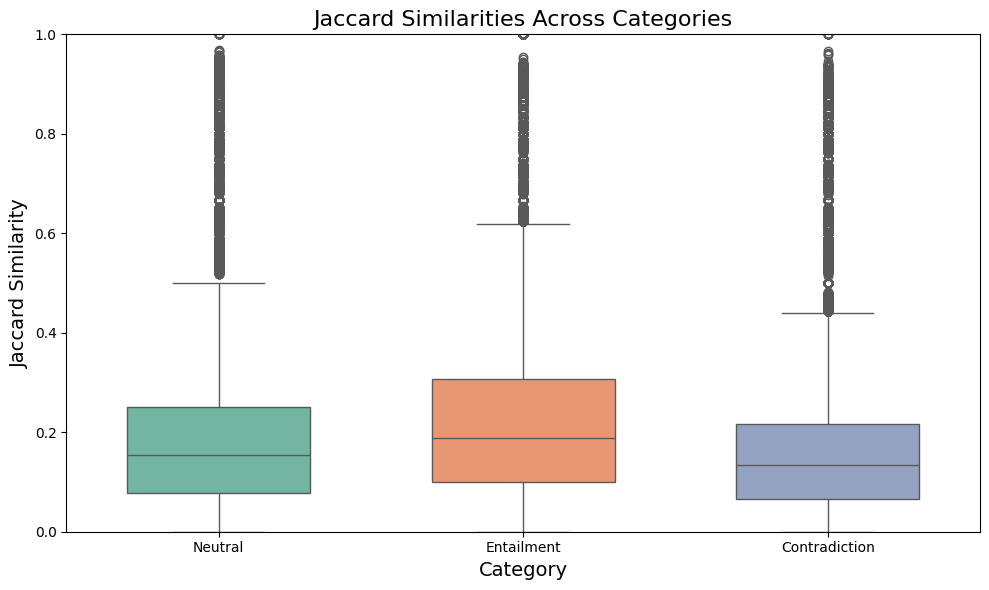

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def jaccard_similarity(set1, set2):
    """
    Calculates the Jaccard similarity between the hypothesis and premise.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def check_jaccard(data):
  """
  Calculates Jaccard similarity for all instances in the data.
  """
  similarity = 0
  amount_of_no_sim = 0
  scores = []
  for key in data:
    item = data[key]
    set1 = set(item['p'].split())
    set2 = set(item['h'].split())
    scores.append(jaccard_similarity(set1, set2))
  return scores

playgroundC = {key: trainDict[key] for key in trainDict if trainDict[key]['g'] == "contradiction"}
playgroundE = {key: trainDict[key] for key in trainDict if trainDict[key]['g'] == "entailment"}
playgroundN = {key: trainDict[key] for key in trainDict if trainDict[key]['g'] == "neutral"}

neutral_scores = check_jaccard(playgroundN)
entailment_scores = check_jaccard(playgroundE)
contradiction_scores = check_jaccard(playgroundC)

categories = (
    ['Neutral'] * len(neutral_scores) +
    ['Entailment'] * len(entailment_scores) +
    ['Contradiction'] * len(contradiction_scores))
all_scores = neutral_scores + entailment_scores + contradiction_scores

data = pd.DataFrame({'Category': categories, 'Jaccard Score': all_scores})

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Category', y='Jaccard Score', palette='Set2', width=0.6)

plt.title('Jaccard Similarities Across Categories', fontsize=16)
plt.ylabel('Jaccard Similarity', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()